In [0]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 47.1MB/s 
     |████████████████████████████████| 450kB 30.4MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [0]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

Using TensorFlow backend.


170500096/170498071 [==============================] - 6s 0us/step


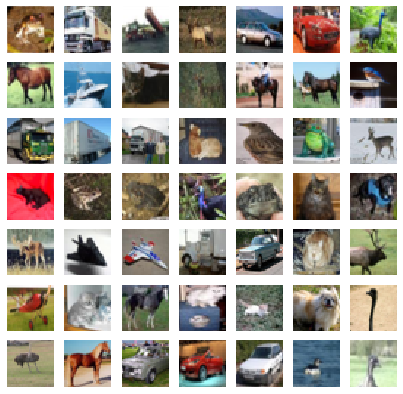

In [0]:
# example of loading and plotting the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(49):
    # define subplot
    pyplot.subplot(7, 7, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()

In [0]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'plots/CIFAR10/GAN_CIFAR10_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, tensorboard, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, d_real_acc = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, d_fake_acc = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('Evaluation du discriminateur : epoch: %d, acc_real: %.0f%%, acc_fake: %.0f%%' % (epoch, d_real_acc*100, d_fake_acc*100))
    logs = {
            'd_real_acc':d_real_acc*100,
            'd_fake_acc':d_fake_acc*100
            }
    tensorboard.on_epoch_end(epoch, logs)
    # save plot
    save_plot(X_fake, epoch)
    # save the generator model tile file
    filename = 'models/CIFAR10/GAN_CIFAR10_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, tensorboard, n_epochs=200, batch_size=128):
    bat_per_epo = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # evaluate the model performance, sometimes
        summarize_performance(i, g_model, d_model, dataset, latent_dim, tensorboard)
        # enumerate batches over the training set
        for j in range(batch_size):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_real_loss, d_real_acc = d_model.train_on_batch(X_real, y_real)
            d_fake_loss, d_fake_acc = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('epoch : %d, batch : %d/%d, d_real_loss=%.3f, d_fake_loss=%.3f, g_loss=%.3f' % (i+1, j+1, batch_size, d_real_loss, d_fake_loss, g_loss))

# Create the TensorBoard callback,
# which we will drive manually
tensorboard = TensorBoard(
  log_dir='/content/drive/My Drive/Colab Notebooks/logs/CIFAR10/',
  histogram_freq=0,
  write_graph=True
)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
tensorboard.set_model(gan_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, tensorboard)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
epoch : 113, batch : 75/128, d_real_loss=0.688, d_fake_loss=0.654, g_loss=0.840
epoch : 113, batch : 76/128, d_real_loss=0.668, d_fake_loss=0.675, g_loss=0.821
epoch : 113, batch : 77/128, d_real_loss=0.655, d_fake_loss=0.648, g_loss=0.827
epoch : 113, batch : 78/128, d_real_loss=0.632, d_fake_loss=0.653, g_loss=0.836
epoch : 113, batch : 79/128, d_real_loss=0.708, d_fake_loss=0.616, g_loss=0.838
epoch : 113, batch : 80/128, d_real_loss=0.617, d_fake_loss=0.603, g_loss=0.823
epoch : 113, batch : 81/128, d_real_loss=0.627, d_fake_loss=0.610, g_loss=0.815
epoch : 113, batch : 82/128, d_real_loss=0.602, d_fake_loss=0.731, g_loss=0.801
epoch : 113, batch : 83/128, d_real_loss=0.649, d_fake_loss=0.645, g_loss=0.862
epoch : 113, batch : 84/128, d_real_loss=0.656, d_fake_loss=0.627, g_loss=0.842
epoch : 113, batch : 85/128, d_real_loss=0.681, d_fake_loss=0.675, g_loss=0.838
epoch : 113, batch : 86/128, d_real_loss=0

In [0]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

# load model
model = load_model('generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)